In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from seqeval.metrics import accuracy_score
from seqeval.metrics import classification_report
from seqeval.metrics import f1_score
from seqeval.metrics import recall_score
from nltk import word_tokenize


import unicodedata
import re
import numpy as np
import os
import io
import time
import json
import pickle

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
path_to_file = "C:\\Kshitij\\DEV\\Datasets\\spider\\train_spider.json"

In [4]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())
  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  #w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [5]:
def create_dataset(path_to_file):
    queries =[]
    questions = []
    train_data = []
    train_labels = []
    
    with open(path_to_file, 'r') as f:
        datastore = json.load(f)

    for i in range(len(datastore)):
        queries.append(preprocess_sentence(datastore[i]['query']))
        questions.append(preprocess_sentence(datastore[i]['question']))
        
    with open("C:\\Kshitij\\DEV\\Datasets\\spider\\dev.json", 'r') as f:
        datastore = json.load(f)

    for i in range(len(datastore)):
        queries.append(preprocess_sentence(datastore[i]['query']))
        questions.append(preprocess_sentence(datastore[i]['question']))
    
#     dbfile = open('C:\\Kshitij\\DEV\\Jupyter\\EVAL\\analysis\\questions_wiki_train.pickle', 'rb')      
#     q1 = pickle.load(dbfile) 
#     dbfile.close()

#     dbfile = open('C:\\Kshitij\\DEV\\Jupyter\\EVAL\\analysis\\queries_wiki_train.pickle', 'rb')      
#     q2 = pickle.load(dbfile) 
#     dbfile.close()

#     for i in q2[:2000]:
#         queries.append(i)
#     for i in q1[:2000]:
#         questions.append(i)
    
    for i in range(len(queries)):
        train_data.append(queries[i])
        train_labels.append(questions[i])

    
    return train_data,train_labels

In [6]:
def max_length(tensor):
  return max(len(t) for t in tensor)

In [7]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [8]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [9]:
# Try experimenting with the size of that dataset
num_examples = 10_000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [10]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
# print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

In [11]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [12]:
# print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
# print ()
# print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

2 ----> <start>
7 ----> what
9 ----> are
1 ----> the
13 ----> names
8 ----> and
207 ----> descriptions
4 ----> of
14 ----> all
1 ----> the
752 ----> sections
5 ----> ?
3 ----> <end>
7 ----> <start>
5 ----> select
1250 ----> section_name
14 ----> ,
2065 ----> section_description
4 ----> from
1251 ----> sections
8 ----> <end>


In [13]:
print(inp_lang.word_index)

{'the': 1, '<start>': 2, '<end>': 3, 'of': 4, '?': 5, '.': 6, 'what': 7, 'and': 8, 'are': 9, 'in': 10, 'is': 11, 'name': 12, 'names': 13, 'all': 14, 'that': 15, 'number': 16, 'with': 17, 'have': 18, 'find': 19, 'for': 20, ',': 21, 'who': 22, 'how': 23, 'many': 24, 'show': 25, 'than': 26, 'each': 27, 'which': 28, 'list': 29, 'by': 30, 'most': 31, 'average': 32, 'a': 33, 'id': 34, 'students': 35, 'first': 36, 'has': 37, 'not': 38, 'order': 39, 'more': 40, 'type': 41, 'last': 42, 'or': 43, 'whose': 44, 'total': 45, 'return': 46, 'ids': 47, 'different': 48, 'to': 49, 'code': 50, 'count': 51, 'customers': 52, 'at': 53, 'from': 54, 'there': 55, 'least': 56, 'any': 57, 'give': 58, 'distinct': 59, 'customer': 60, 'do': 61, 'their': 62, 'year': 63, 'department': 64, 'date': 65, 'employees': 66, 'city': 67, 'product': 68, 'products': 69, 'me': 70, 'age': 71, 'as': 72, 'players': 73, 'both': 74, 'maximum': 75, 'student': 76, 'ordered': 77, 'country': 78, 'amount': 79, 'cities': 80, 'price': 81, '

In [14]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 100
units = 175
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [15]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 44]), TensorShape([64, 130]))

In [16]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [17]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

In [18]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [19]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

In [20]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [21]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

In [22]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [23]:
checkpoint_dir = '../training_checkpoints_more1'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [24]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '
    

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [25]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [26]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

#   print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [27]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Predicted translation: select max(area_code) , min(weeks_on_top) from rating) <end> 


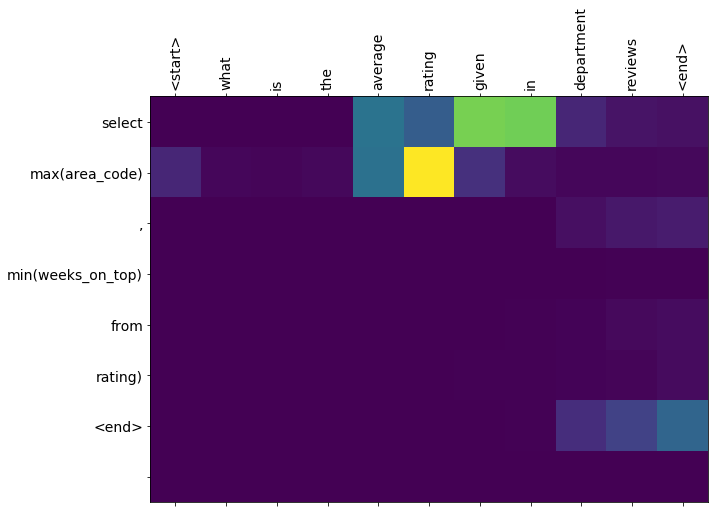

In [28]:
translate("what is the average rating given in department reviews")

Predicted translation: select distinct t1 . age from management as t2 on t1 . head_id = t2 . head_id where t2 . temporary_acting = 'yes' <end> 


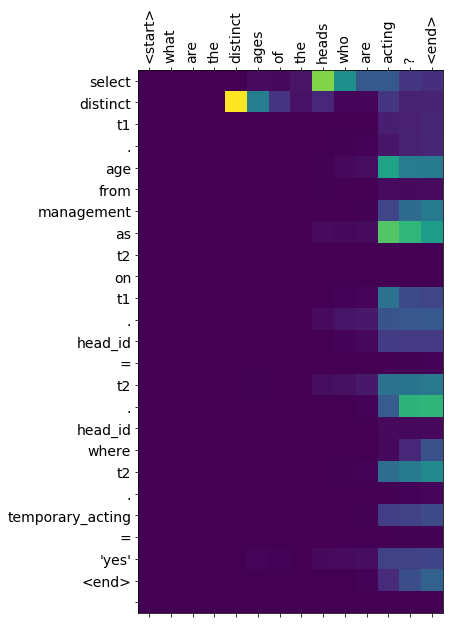

In [29]:
translate("What are the distinct ages of the heads who are acting?")

Predicted translation: select player from course <end> 


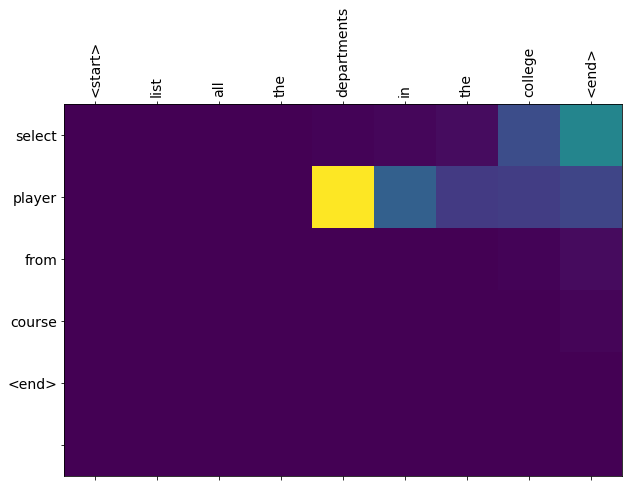

In [30]:
translate("LIST ALL THE DEPARTMENTS IN THE COLLEGE")

In [31]:
def translate1(sentence):
    result, sentence, attention_plot = evaluate(sentence)
    return result

In [32]:
SQL_key = ['ON','FROM', 'REPLACE', 'SELECT', 'INSERT', 'AS', 'IS', 'TRUNCATE', 'EXISTS', 'VALUES', 'PRIMARY', 'MAX', 'UNION', 'A', 'TABLE', 'JOIN', 'UPDATE', 'ALL', 'OR', 'NULL', 'ALTER', 'TOP', 'AND', 'DELETE', 'LEFT', 'IN', 'ANY', 'SQL', 'RIGHT', 'HAVING', 'KEY', 'DATABASE', 'DESC', 'EXEC', 'COUNT', 'CONSTRAINT', 'INDEX', 'GROUP', 'PROCEDURE', 'FOREIGN', 'LIMIT', 'BACKUP', 'OUTER', 'ORDER', 'WHERE', 'DEFAULT', 'DROP', 'CHECK', 'NOT', 'ROWNUM', 'ADD', 'AVG', 'MIN', 'INTO', 'CASE', 'FULL', 'VIEW', 'DISTINCT', 'ASC', 'UNIQUE', 'SUM', 'LIKE', 'BY', 'BETWEEN', 'INNER', 'COLUMN', 'SET', 'CREATE']
operators = ['.','\"','\'','=', '>', '<', '>', '=', '<=', '<>', '+', '-', '*', '/', '%', '+=', '-=', '*=', '/=', '%=', '(', ')']

def pre_proc(x):
    resp = []
    resp.append("select")
    str1 = x
    for i in word_tokenize(str1)[1:]:
        if(i.upper() not in SQL_key and i not in operators):
            resp.append('O')
        else:
            resp.append(i)
    return resp

def tag_imp(x):
    resp = []
    x = pre_proc(x)
    resp.append("B-KEY")
    for i in x[1:]:
        if(i.upper() in SQL_key):
            if(resp[-1] == "B-KEY"):
                resp.append("I-key")
            else:
                resp.append("B-KEY")
        elif(i in operators):
            if(resp[-1] == "B-op"):
                resp.append("I-op")
            else:
                resp.append("B-op")
        elif(i == "O"):
            if(resp[-1] == "B-tbl"):
                resp.append("I-tbl")
            else:
                resp.append("B-tbl")
        else:
            resp.append("O")
    return resp

In [36]:
def eval_test(test_data):
    y_pred = []
    y = []
    questions = []
    queries = []
    
    for i in range(len(test_data)):
        questions.append(test_data[i])
    
    with open("C:\\Kshitij\\DEV\\Datasets\\spider\\train_others.json", 'r') as f:
        datastore = json.load(f)

    for i in range(len(datastore)):
        queries.append(preprocess_sentence(datastore[i]['query']))
    
    def dumb_token(sent):
        sent1 = re.findall(r"\'[A-Z,a-z]",sent)
        if(len(sent1)>0):
            sent2 = sent.replace(sent1[0],"'"+" "+sent1[0][1:])
            return sent2
        else:
            return sent
    
    for i in range(len(queries)):
        actual_query = dumb_token(queries[i].lower())
        pred_query = translate1(questions[i])
        pred_query = dumb_token(pred_query[:-6])
        
        y.append(tag_imp(actual_query))
        y_pred.append(tag_imp(pred_query))
        print(y)
        print(y_pred)
        
        break
        
    accuracy = 0

    for i in range(len(y)):
        acc_query = accuracy_score(y[i],y_pred[i])
        accuracy += acc_query
    
    print("ACCURACY:")
    print(accuracy/len(y))

In [37]:
dbfile = open('C:\\Kshitij\\DEV\\Datasets\\spider\\analysis\\test_questions_spider.pickle', 'rb')      
questions_test = pickle.load(dbfile) 
dbfile.close()

In [38]:
eval_test(questions_test)

[['B-KEY', 'B-tbl', 'B-op', 'B-KEY', 'B-tbl', 'B-KEY', 'B-tbl', 'B-KEY', 'B-tbl', 'B-op', 'I-op', 'B-KEY', 'I-key', 'B-op', 'B-tbl', 'B-op', 'B-KEY', 'B-tbl', 'B-KEY', 'B-tbl', 'B-op', 'B-tbl', 'B-op', 'B-KEY', 'B-tbl', 'B-op', 'B-tbl', 'I-tbl', 'B-op', 'B-tbl', 'B-op']]
[['B-KEY', 'B-op', 'B-KEY', 'B-tbl', 'B-KEY', 'B-tbl', 'B-op', 'B-tbl']]
ACCURACY:
0.03225806451612903
